<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 5ème projet de ma formation Datascientist dispensée en MOOC par 
**<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>**.
</p>    

<p>
Ce notebook présente un modèle de ségmentation de clients d'un site d'achats en ligne. 
</p>
<p>
Ce modèle se base sur les données fournies par le site :
</p>
<p>
https://archive.ics.uci.edu/ml/datasets/Online+Retail
</p>
<p>
Ce notebook implémente les phases de l'analyse exploratoire de la caractéristique RFM.
Les étapes de l'analyse sont :     
</p>
* l'acquisition des données issues du sampling réalisé dans le notebook ``P5_2.ipynb``
* la construction de la caractéristique ``RFM``  
* la construction de nouvelles variables par un encodage de la caractéristique ``RFM``
* La recherche des paramètres optimaux pour les algorithmes de clustering:
    * ``Kmeans``
    * ``DBSCAN``
    * ``GMM``

**Les résultats de cette analyse sont reprise dans le notebook <font color='blue'>*P5_AllFeature.ipynb*</font>**. 

Ce dernier notebook permet d'évaluer les différents modèles de prédiction.

In [1]:
import pandas as pd
import numpy as np
import time

import warnings
warnings.filterwarnings("ignore")


import p3_util
import p3_util_plot
import p5_util
import p5_util_plot

#--------------------------
# Process flow parameters
#--------------------------
is_reloaded = True

#---------------------------------------------------------------------------
# Outliers values issued from Total feature are removed or not from dataset.
is_total_no_outliers = False
#---------------------------------------------------------------------------

#---------------------------------------------------------------------------
# Encoded RFM features are clusterized separatly from other features.
#---------------------------------------------------------------------------
is_rfm_cluster = True

#### <font color='blue'>Restore *df_invoice_line* dataframe</font>

In [2]:
import p5_util
if is_reloaded is True:
    df_invoice_line =  p5_util.p5_reload_data_sample()
    print(df_invoice_line.shape)    


p5_util.object_load : fileName= ./data/df_invoice_line_sample_random.dump
(194907, 7)
(194907, 7)


In [3]:
nb_invoices = len(df_invoice_line['InvoiceNo'].unique())
print("\n*** Nombre de factures= "+str(nb_invoices))


*** Nombre de factures= 9330


# <font color='blus'>Building RFM features</font>

In [4]:
import p5_util
#-------------------------------------------------------------------------------
# day_now = None : Most recent value from dataframe will be fixed for day_now.
day_now = None
#-------------------------------------------------------------------------------
df_invoice_line, df_RFM,  df_RFM_quantiles, day_now = p5_util.p5_df_rfm_build(df_invoice_line, day_now)

In [5]:
print(df_RFM_quantiles)

    Frequency  Recency  Monatary  neg_recency
Q1        1.0     16.0   296.170       -140.0
Q2        2.0     49.0   654.025        -49.0
Q3        5.0    140.0  1552.130        -16.0


In [6]:
import p3_util_plot
nb_rfm = len(df_RFM.RFM.unique())
p3_util_plot.printmd("Nb de classes RFM : "+str(nb_rfm))
p3_util_plot.printmd("Echantillon de client(e)s classé(e)s RFM : "+str(df_RFM.shape[0]))
df_RFM.sample(1)

<p><font color='green'>**Nb de classes RFM : 59**</font></p>

<p><font color='green'>**Echantillon de client(e)s classé(e)s RFM : 2124**</font></p>

,CustomerID,Frequency,Recency,Monatary,neg_recency,R_score,F_score,M_score,RFM
1393,16461,1,177,142.92,-25,2,4,4,244


####  Backup of dataframe

In [7]:
import p5_util

fileName = './data/df_RFM.dump'
p5_util.object_dump(df_RFM,fileName)

**<font color='blue'>*RFM*</font> column from <font color='blue'>*df_RFM*</font> dataframe is aggregated to <font color='blue'>*df_invoice_line*</font> columns**

In [8]:
df_invoice_line = pd.merge(df_invoice_line, df_RFM[['CustomerID','RFM']], how='left', on=['CustomerID'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Total,RFM
90271,559940,23170,REGENCY TEA PLATE ROSES,36,15169,1.45,17396,52.2,111


In [116]:
df_invoice_line.sample()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Total,RFM,TotalInt,RFMInt
90794,560103,22138,BAKING SET 9 PIECE RETROSPOT,3,15170,4.95,17837,14.85,112,14,112


### Total = F(Invoices)

,Invoices,Total
CustomerID,,
14778,35,730.86


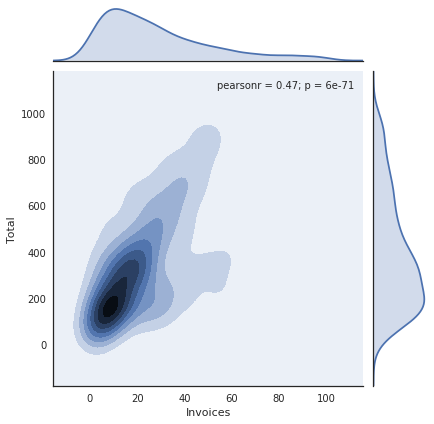

In [140]:
import seaborn as sns
feature1 = "Total"
feature2 = "InvoiceNo"
df_data = df_invoice_line[[feature1,feature2,'CustomerID']]
df_data_total = df_data.groupby('CustomerID').agg({feature1: lambda x: sum(x)})
df_data_total = df_data_total.query(feature1+'<1000')

df_data_inv = df_data.groupby('CustomerID').agg({feature2: lambda x: len(x)})
df_data_inv = df_data_inv.query(feature2+'<100')
df_data_inv.rename(columns={feature2:'Invoices'},inplace=True)
feature2 = "Invoices"

df_data_all = pd.concat([df_data_inv, df_data_total], axis=1, join='inner')
if True:
    with sns.axes_style('white'):
        sns.jointplot(feature2, feature1, df_data_all, kind='kde');
        #sns.jointplot("InvoiceNo", "Total", df_data_all, kind='hex');
        
df_data_all.sample()


### Total = F(Invoice lines)

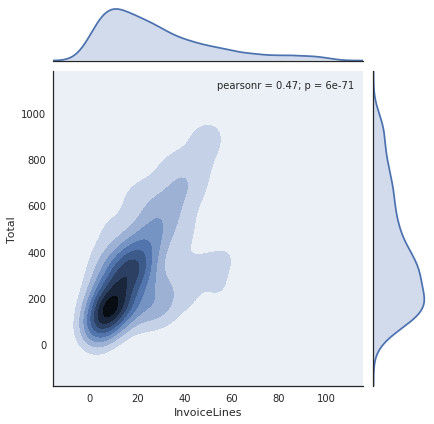

In [136]:
import seaborn as sns
feature1= 'Total'
feature2= 'StockCode'
df_data = df_invoice_line[[feature1, feature2,'CustomerID']]
df_data_feature1 = df_data.groupby('CustomerID').agg({feature1: lambda x: sum(x)})
df_data_feature1 = df_data_total.query(feature1+'<1000')

df_data_feature2 = df_data.groupby('CustomerID').agg({feature2: lambda x: len(x)})
df_data_feature2 = df_data_feature2.query(feature2+'<100')
df_data_feature2.rename(columns={'StockCode':'InvoiceLines'}, inplace=True)
feature2 = 'InvoiceLines'

df_data_all = pd.concat([df_data_feature1, df_data_feature2], axis=1, join='inner')
if True:
    with sns.axes_style('white'):
        sns.jointplot(feature2, feature1, df_data_all, kind='kde', title="Total=f("+feature2+")");
        #sns.jointplot(feature1, feature2, df_data_all, kind='hex');
        

,Total,UnitPrice
CustomerID,,
13210,353.48,1.511818


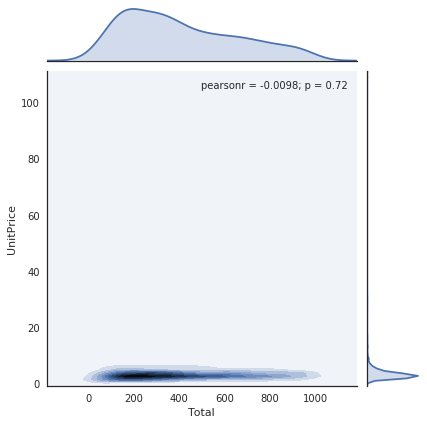

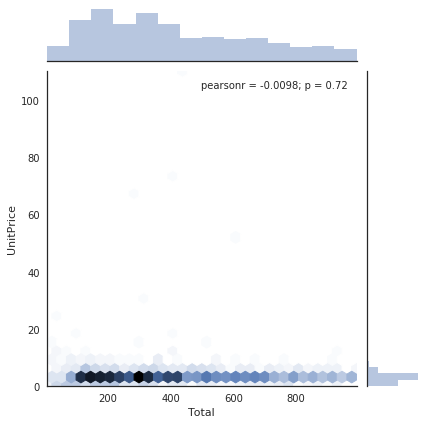

In [120]:
import seaborn as sns
feature1= 'Total'
feature2= 'UnitPrice'
df_data = df_invoice_line[[feature1, feature2,'CustomerID']]
df_data_feature1 = df_data.groupby('CustomerID').agg({feature1: lambda x: sum(x)})
df_data_feature1 = df_data_total.query(feature1+'<1000')

df_data_feature2 = df_data.groupby('CustomerID').agg({feature2: lambda x: sum(x)/len(x)})
#df_data_feature2 = df_data_feature2.query(feature2+'<100')


df_data_all = pd.concat([df_data_feature1, df_data_feature2], axis=1, join='inner')
if True:
    with sns.axes_style('white'):
        sns.jointplot(feature1, feature2, df_data_all, kind='kde');
        sns.jointplot(feature1, feature2, df_data_all, kind='hex');
        
df_data_all.sample()


### Total = F(Quantities)

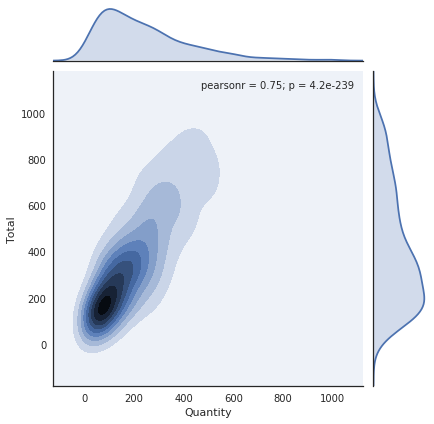

In [141]:
import seaborn as sns
feature1= 'Total'
feature2= 'Quantity'
df_data = df_invoice_line[[feature1, feature2,'CustomerID']]
df_data_feature1 = df_data.groupby('CustomerID').agg({feature1: lambda x: sum(x)})
df_data_feature1 = df_data_total.query(feature1+'<1000')

df_data_feature2 = df_data.groupby('CustomerID').agg({feature2: lambda x: sum(x)})
df_data_feature2 = df_data_feature2.query(feature2+'<1000')


df_data_all = pd.concat([df_data_feature1, df_data_feature2], axis=1, join='inner')
if True:
    with sns.axes_style('white'):
        sns.jointplot(feature2, feature1, df_data_all, kind='kde');
        


# <font color='blus'>One hot encoding of RFM values </font>

In [9]:
import pandas as pd


rfm_encoder, df_RFM_encoded = p5_util.df_rfm_one_hot_encode(df_RFM,'RFM')
df_encoded, list_col_unchanged = p5_util.df_rename_columns(df_RFM_encoded, df_RFM_encoded.columns, 'w_rfm_')
print(df_RFM_encoded.shape)
print(df_RFM_encoded.columns)

(2124, 59)
Index(['w_rfm_0', 'w_rfm_1', 'w_rfm_2', 'w_rfm_3', 'w_rfm_4', 'w_rfm_5',
       'w_rfm_6', 'w_rfm_7', 'w_rfm_8', 'w_rfm_9', 'w_rfm_10', 'w_rfm_11',
       'w_rfm_12', 'w_rfm_13', 'w_rfm_14', 'w_rfm_15', 'w_rfm_16', 'w_rfm_17',
       'w_rfm_18', 'w_rfm_19', 'w_rfm_20', 'w_rfm_21', 'w_rfm_22', 'w_rfm_23',
       'w_rfm_24', 'w_rfm_25', 'w_rfm_26', 'w_rfm_27', 'w_rfm_28', 'w_rfm_29',
       'w_rfm_30', 'w_rfm_31', 'w_rfm_32', 'w_rfm_33', 'w_rfm_34', 'w_rfm_35',
       'w_rfm_36', 'w_rfm_37', 'w_rfm_38', 'w_rfm_39', 'w_rfm_40', 'w_rfm_41',
       'w_rfm_42', 'w_rfm_43', 'w_rfm_44', 'w_rfm_45', 'w_rfm_46', 'w_rfm_47',
       'w_rfm_48', 'w_rfm_49', 'w_rfm_50', 'w_rfm_51', 'w_rfm_52', 'w_rfm_53',
       'w_rfm_54', 'w_rfm_55', 'w_rfm_56', 'w_rfm_57', 'w_rfm_58'],
      dtype='object')


#### Backup dumped file 

In [10]:
import p5_util

fileName = './data/df_customers_RFM.dump'
p5_util.object_dump(df_RFM_encoded, fileName)

# <font color='blus'> PCA over RFM : none</font>

#### Restore dataframe 

# <font color='blus'> Clustering RFM features</font>

#### Loading dumped file into *df_customers* dataframe

In [11]:
import p5_util
if is_reloaded is True:
    fileName = './data/df_customers_rfm.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers_rfm.dump
(2124, 59)


## <font color='blue'> Kmeans Clustering time features</font>

In [12]:
import p5_util
cluster_start = 1
cluster_end = 11
dict_kmeans = p5_util.kmeans_scan_inter_inertia(df_customers, cluster_start, cluster_end)

Clustering : 1 clusters
Clustering : 2 clusters
Clustering : 3 clusters
Clustering : 4 clusters
Clustering : 5 clusters
Clustering : 6 clusters
Clustering : 7 clusters
Clustering : 8 clusters
Clustering : 9 clusters
Clustering : 10 clusters


#### Save of Kmeans clustering scan from time features into a dumped file

In [13]:
import p5_util

fileName = './data/clustering_dict_kmeans_RFM.dump'
p5_util.object_dump(dict_kmeans, fileName)

#### Time features : Plot Clusters = F(inter-inertia)

p5_util.object_load : fileName= ./data/clustering_dict_kmeans_RFM.dump
Records into Time feaures dict_kmeans= 10
1 10


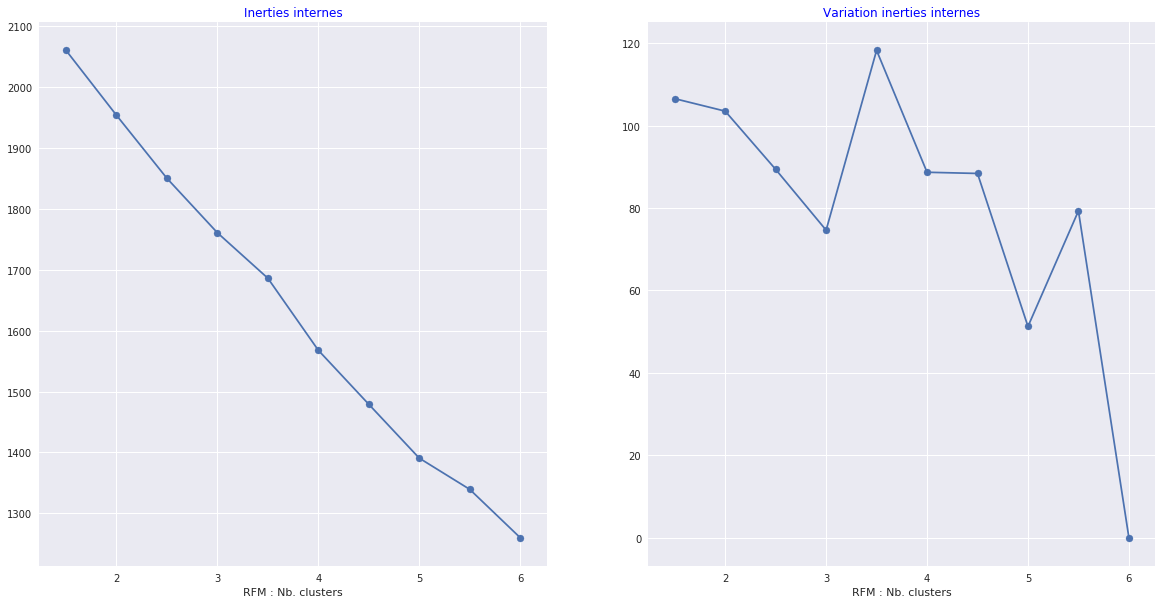

In [14]:
import p5_util_plot
import p5_util

if is_reloaded is True:
    fileName = './data/clustering_dict_kmeans_RFM.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Records into Time feaures dict_kmeans= "+str(len(dict_kmeans)))

x_label_0 = 'RFM : Nb. clusters'
x_label_1 = 'RFM : Nb. clusters'
cluster_start = list(dict_kmeans.keys())[0]
cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
print(cluster_start, cluster_end)
p5_util_plot.plot_kmeans_interInertia(dict_kmeans, cluster_start, cluster_end\
                             ,[x_label_0, x_label_1]\
                             ,p_rows=1, p_cols=2, p_figsize=(20,10))

#### Clustering : RFM silhouette

In [15]:
import p5_util
import p5_util_plot

if True:
    fileName = './data/df_customers_rfm.dump'
    df_customers = p5_util.object_load(fileName)
    print("Time features : "+str(df_customers.shape))
    
    #-------------------------------------------------------------------------------
    # Use kmeans dictionary to get numbers of clusters
    #-------------------------------------------------------------------------------
    fileName = './data/clustering_dict_kmeans_RFM.dump'
    dict_kmeans = p5_util.object_load(fileName)
    print("Clusters into RFM features dict_kmeans= "+str(len(dict_kmeans)))
    cluster_start = list(dict_kmeans.keys())[0]
    #if 1 == cluster_start :
    #    cluster_start = 2
    cluster_end = list(dict_kmeans.keys())[len(dict_kmeans)-1]
    print("Cluster start = "+str(cluster_start)+" Cluster end= "+str(cluster_end))


dict_cluster_kmeans_silhouette = p5_util.kmeans_scan_silhouette(df_customers, cluster_start, cluster_end)

p5_util.object_load : fileName= ./data/df_customers_rfm.dump
Time features : (2124, 59)
p5_util.object_load : fileName= ./data/clustering_dict_kmeans_RFM.dump
Clusters into RFM features dict_kmeans= 10
Cluster start = 1 Cluster end= 10
Cluster 2 done!
Cluster 3 done!
Cluster 4 done!
Cluster 5 done!
Cluster 6 done!
Cluster 7 done!
Cluster 8 done!
Cluster 9 done!


#### Backup silhouette clustering result

In [16]:
import p5_util
fileName = './data/dict_cluster_kmeans_silhouette_RFM.dump'
p5_util.object_dump(dict_cluster_kmeans_silhouette,fileName)

#### Plotting silhouette = F(nb clusters)

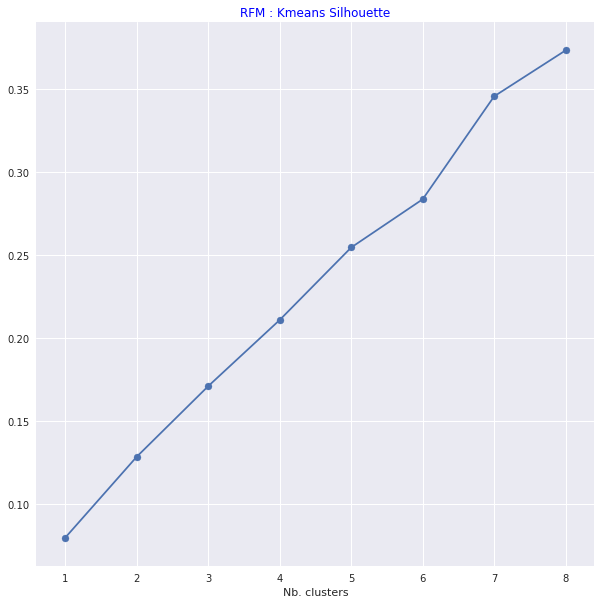

In [17]:
p_title='RFM : Kmeans Silhouette'
p5_util_plot.plot_kmeans_silhouette(dict_cluster_kmeans_silhouette, p_title, p_figsize=(10,10))

Coefficient increases as number of clusters increase.

### <font color='blue'>Cluster model with best number of clusters</font>

In [18]:
n_cluster=8

In [19]:
from sklearn.cluster import KMeans
from sklearn import metrics
X = df_customers.values

#csr_invoice_matrix = sparse.csr_matrix(df_RFM_encoded.values)
cluster_kmean = KMeans(n_clusters=n_cluster).fit(X)

# Predict the cluster for each data point
preds_kmean = cluster_kmean.predict(X)

### <font color='blue'>Adding *cluster* issue fro clustering into *df_customers*  as a new feature</font>

In [20]:
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
df_customers.shape,preds_kmean.shape

((2124, 59), (2124,))

In [21]:
import p5_util

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, preds_kmean)
print(df_customers.shape)

(2124, 59)
(2124, 60)


In [22]:
df_customers.columns

Index(['cluster', 'w_rfm_0', 'w_rfm_1', 'w_rfm_2', 'w_rfm_3', 'w_rfm_4',
       'w_rfm_5', 'w_rfm_6', 'w_rfm_7', 'w_rfm_8', 'w_rfm_9', 'w_rfm_10',
       'w_rfm_11', 'w_rfm_12', 'w_rfm_13', 'w_rfm_14', 'w_rfm_15', 'w_rfm_16',
       'w_rfm_17', 'w_rfm_18', 'w_rfm_19', 'w_rfm_20', 'w_rfm_21', 'w_rfm_22',
       'w_rfm_23', 'w_rfm_24', 'w_rfm_25', 'w_rfm_26', 'w_rfm_27', 'w_rfm_28',
       'w_rfm_29', 'w_rfm_30', 'w_rfm_31', 'w_rfm_32', 'w_rfm_33', 'w_rfm_34',
       'w_rfm_35', 'w_rfm_36', 'w_rfm_37', 'w_rfm_38', 'w_rfm_39', 'w_rfm_40',
       'w_rfm_41', 'w_rfm_42', 'w_rfm_43', 'w_rfm_44', 'w_rfm_45', 'w_rfm_46',
       'w_rfm_47', 'w_rfm_48', 'w_rfm_49', 'w_rfm_50', 'w_rfm_51', 'w_rfm_52',
       'w_rfm_53', 'w_rfm_54', 'w_rfm_55', 'w_rfm_56', 'w_rfm_57', 'w_rfm_58'],
      dtype='object')

### <font color='blue'>Showing elements count per cluster</font>

Clusters = [0 1 2 3 4 5 6 7]
Population cumulée par cluster = 2124
         Count
cluster       
0          973
1           99
2           92
3           93
4          106
5          109
6           63
7          589


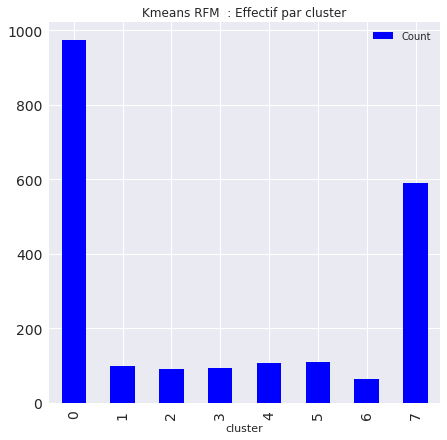

In [23]:
import p5_util_plot
p5_util_plot.plot_cluster_frequency(df_customers, p_title='Kmeans RFM ')

# <font color='blus'> DBSCAN clustering</font>

#### Distances distribution

In [24]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
    
distances = pdist(df_customers.values, metric='euclidean')

print(np.min(distances), np.max(distances))



x_med = np.median(distances)
print("Distance median = "+str(x_med))
print("Nb elts de distances= "+str(len(distances)))
len(np.where(distances<x_med)[0])

raws = df_customers.shape[0]
print("Distance elts computing : n*(n+1)/2 - n = "+str(int((raws*(raws+1)/2)-raws)))

df_dist = pd.DataFrame(distances)

df_dist_quantiles = df_dist.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95])

df_dist_quantiles.rename(columns={0:'Distance'},inplace=True)
df_dist_quantiles

0.0 1.4142135623730951
Distance median = 1.4142135623730951
Nb elts de distances= 2254626
Distance elts computing : n*(n+1)/2 - n = 2254626


,Distance
0.15,1.414214
0.25,1.414214
0.50,1.414214
0.75,1.414214
0.95,1.414214


In [25]:
p_eps=1.4

#### Computing nb neighbours for 95% fo distances

In [26]:
import numpy as np

dist_matrix = squareform(distances)
print(dist_matrix.shape)
dict_ball_neighbour = dict()
for raw in range(0,dist_matrix.shape[0]):
    dict_ball_neighbour[raw] = len(np.where(dist_matrix[raw]<= p_eps)[0])

(2124, 2124)


In [27]:
ser_ball_neighbour = pd.Series(dict_ball_neighbour)
ser_neighbour_quantiles = ser_ball_neighbour.quantile(q=[0.15, 0.25 ,0.5, 0.75, 0.95, 1.0])
ser_neighbour_quantiles

0.15     29.0
0.25     33.0
0.50     63.0
0.75     92.0
0.95    109.0
1.00    109.0
dtype: float64

### DBSCAN clustering

In [28]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=p_eps,min_samples=100, n_jobs=3)
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
pred_dbscan =  dbscan.fit_predict(df_customers)

import numpy as np
np.unique(pred_dbscan)

array([-1,  0,  1], dtype=int32)

(2124, 59)
(2124, 60)
Clusters = [-1  0  1]
Population cumulée par cluster = 2124
         Count
cluster       
-1        1909
 0         109
 1         106


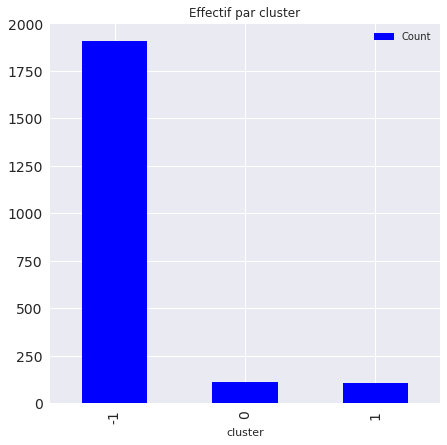

In [29]:
import p5_util
import p5_util_plot

print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_dbscan)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

# <font color='blus'>GMM clustering</font>

#### Restore dataframe 

In [30]:
import p5_util

if is_reloaded is True:
    fileName = './data/df_customers_RFM.dump'
    df_customers = p5_util.object_load(fileName)
    print(df_customers.shape)

p5_util.object_load : fileName= ./data/df_customers_RFM.dump
(2124, 59)


In [31]:
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])

#### Clusters range to search for

In [32]:
cluster_start = 1
cluster_end = df_customers.shape[1]

#### GMM clustering evaluation : using BIC and AIC criterias
* AIC : mesure de la qualité du modele statistique. C'est une mesure de la perte d'information lorsque plusieurs modeles sont proposés, ceux-cic étant de complexité croissante.
* BIC : dérive de l'AIC

Objectif : minimiser ces deux critères.

#### Validation en croisant les hyper-paramètres de GMM

In [33]:
from sklearn.mixture import GaussianMixture
#cluster_start = 1
#cluster_end = 20
X = df_customers.values
n_components = np.arange(cluster_start, cluster_end)
print("Clustering from clusters range from : "+str(cluster_start)+" --> "+str(cluster_end))
dict_covariance_type = {1:'diag', 2:'spherical', 3:'full'}
dict_list_gmm_model = dict()
for key, p_covariance_type in dict_covariance_type.items():
    print("Covariance type = "+str(p_covariance_type))
    #---------------------------------------------------------------------------------------------
    # For a given covariance type, GMM models ranging from cluster_start to cluster_end are built
    #---------------------------------------------------------------------------------------------
    list_gmm_model = [ GaussianMixture(n, covariance_type=p_covariance_type, random_state=0).fit(X) for n in n_components]
    dict_list_gmm_model[p_covariance_type] = list_gmm_model

Clustering from clusters range from : 1 --> 59
Covariance type = diag
Covariance type = spherical
Covariance type = full


#### Display AIC and BIC considering clusters number

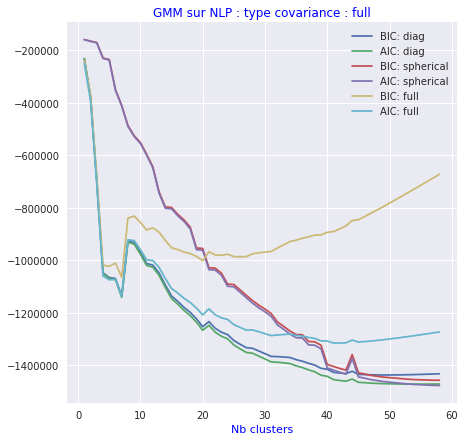

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
for p_covariance_type, list_gmm_model in dict_list_gmm_model.items():
    # For any GMM model from list_gmm_model, compute and plot both BIC and AIC 
    plt.plot(n_components, [model.bic(X) for model in list_gmm_model], label='BIC: '+str(p_covariance_type))
    plt.plot(n_components, [model.aic(X) for model in list_gmm_model], label='AIC: '+str(p_covariance_type))
    plt.legend(loc='best')
    plt.title("GMM sur NLP : type covariance : "+p_covariance_type, color='blue')
    plt.xlabel('Nb clusters', color='blue');

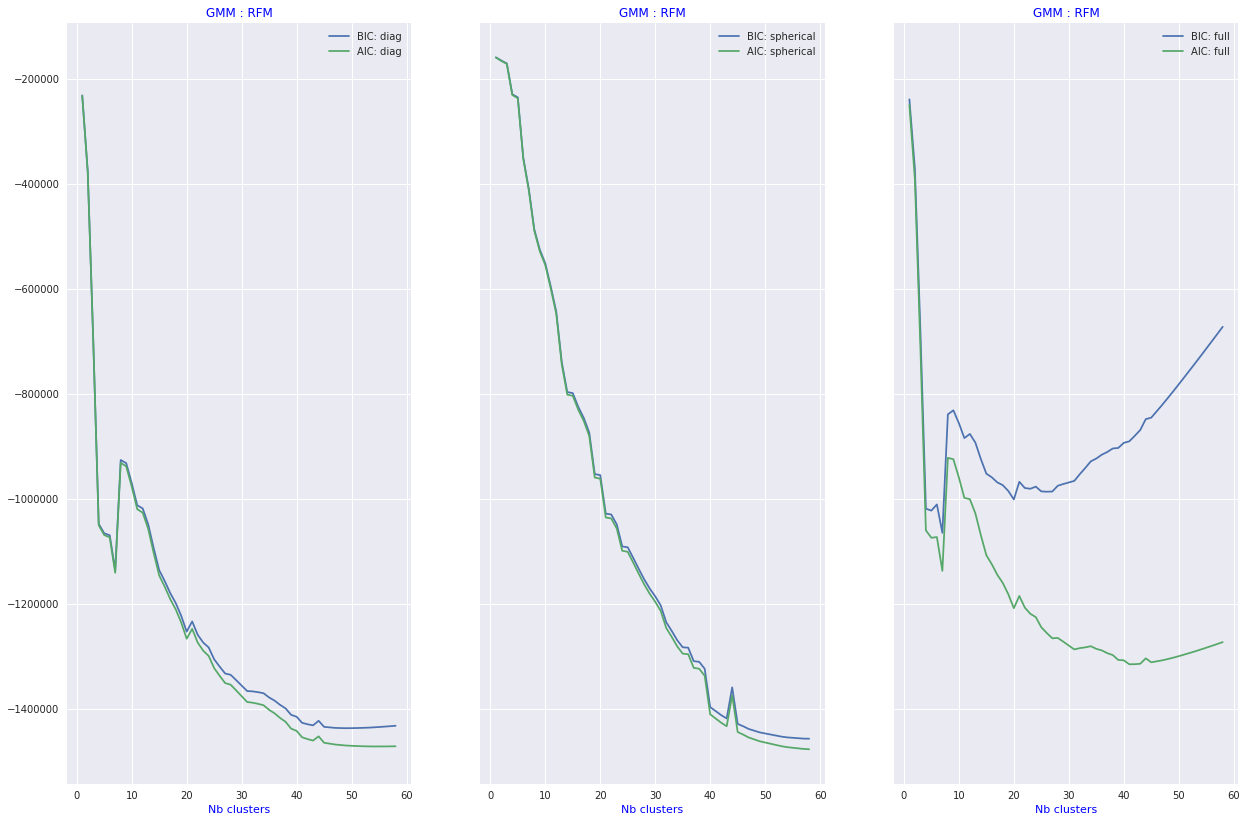

In [35]:
p_figsize = (21,14)
f, ax = plt.subplots(1, 3, figsize=p_figsize, sharex=True, sharey=True)
range_area = range(0,3)

for t_cov_listModel,col_area in zip(dict_list_gmm_model.items(),range_area):
    p_covariance_type = t_cov_listModel[0]
    list_gmm_model = t_cov_listModel[1]

    # For any GMM model from list_gmm_model, compute and plot both BIC and AIC 
    ax[col_area].plot(n_components, [model.bic(X) for model in list_gmm_model], label='BIC: '+str(p_covariance_type))
    ax[col_area].plot(n_components, [model.aic(X) for model in list_gmm_model], label='AIC: '+str(p_covariance_type))
    ax[col_area].legend(loc='best')
    ax[col_area].set_title("GMM : RFM", color='blue')
    ax[col_area].set_xlabel('Nb clusters', color='blue');

#### GMM models evaluation:  silhouette score

In [36]:
from sklearn.metrics import silhouette_score

dict_dict_silhouette_score = dict()
X =df_customers.values
if 1 == cluster_start:
    cluster_start = 2

for p_covariance_type, list_gmm_model in dict_list_gmm_model.items():
    cluster = cluster_start
    dict_silhouette_score = dict()
    print("GMM Silhouette score: Covariance = "+p_covariance_type)
    for gmm_model in list_gmm_model:
        if 1 == gmm_model.n_components:
            pass
        else:
            preds_gmm = gmm_model.predict(X)
            dict_silhouette_score[cluster] = silhouette_score(X, preds_gmm)
            print("GMM Silhouette score: Cluster= "+str(cluster))
            cluster +=1
    dict_dict_silhouette_score[p_covariance_type] = dict_silhouette_score
    print("")

GMM Silhouette score: Covariance = diag
GMM Silhouette score: Cluster= 2
GMM Silhouette score: Cluster= 3
GMM Silhouette score: Cluster= 4
GMM Silhouette score: Cluster= 5
GMM Silhouette score: Cluster= 6
GMM Silhouette score: Cluster= 7
GMM Silhouette score: Cluster= 8
GMM Silhouette score: Cluster= 9
GMM Silhouette score: Cluster= 10
GMM Silhouette score: Cluster= 11
GMM Silhouette score: Cluster= 12
GMM Silhouette score: Cluster= 13
GMM Silhouette score: Cluster= 14
GMM Silhouette score: Cluster= 15
GMM Silhouette score: Cluster= 16
GMM Silhouette score: Cluster= 17
GMM Silhouette score: Cluster= 18
GMM Silhouette score: Cluster= 19
GMM Silhouette score: Cluster= 20
GMM Silhouette score: Cluster= 21
GMM Silhouette score: Cluster= 22
GMM Silhouette score: Cluster= 23
GMM Silhouette score: Cluster= 24
GMM Silhouette score: Cluster= 25
GMM Silhouette score: Cluster= 26
GMM Silhouette score: Cluster= 27
GMM Silhouette score: Cluster= 28
GMM Silhouette score: Cluster= 29
GMM Silhouette s

#### Plot silhouette score for any type of covariance anf for any type of GMM model

* For each covariance type (spherical, diag and full), GMM models ranging from *cluster_start* to *cluster_end* have been built

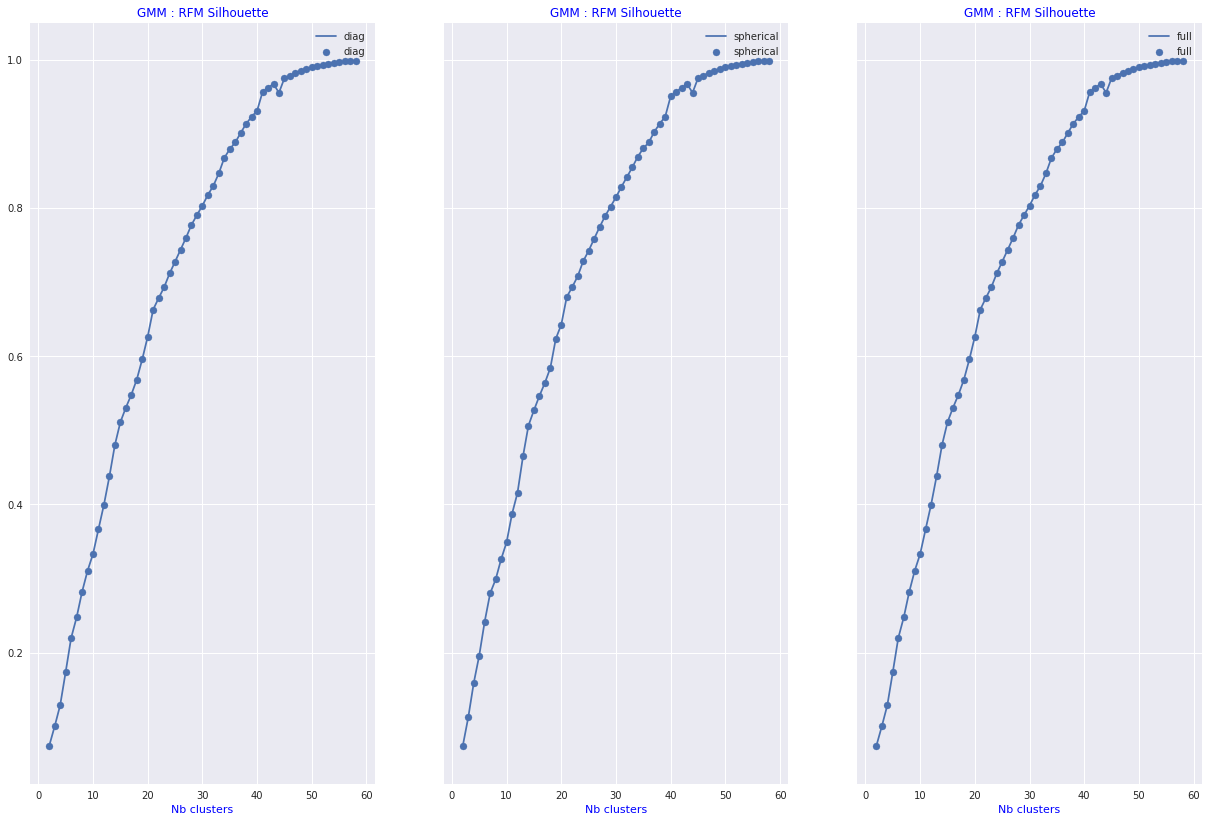

In [37]:
import matplotlib.pyplot as plt

p_figsize = (21,14)
f, ax = plt.subplots(1, 3, figsize=p_figsize, sharex=True, sharey=True)
range_area = range(0,3)

range_area = range(0,3)
for p_covariance_type,col_area in zip(dict_dict_silhouette_score,range_area):
    dict_silhouette_score = dict_dict_silhouette_score[p_covariance_type]    
    
    # For any GMM model from list_gmm_model, compute and plot both BIC and AIC 
    ax[col_area].plot(dict_silhouette_score.keys(), dict_silhouette_score.values(), label=str(p_covariance_type))
    ax[col_area].scatter(dict_silhouette_score.keys(), dict_silhouette_score.values(), label=str(p_covariance_type))
    ax[col_area].legend(loc='best')
    ax[col_area].set_title("GMM : RFM Silhouette", color='blue')
    ax[col_area].set_xlabel('Nb clusters', color='blue');

#### Selection of best clusters count

In [38]:
cluster = cluster_end-2
p_covariance_type = 'spherical'
list_gmm_model = dict_list_gmm_model[p_covariance_type]
gmm_model = list_gmm_model[cluster]
n_cluster = gmm_model.n_components
gmm_model

GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=58, n_init=1,
        precisions_init=None, random_state=0, reg_covar=1e-06, tol=0.001,
        verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)

(2124, 59)
(2124, 60)
Clusters = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
Population cumulée par cluster = 2124
         Count
cluster       
0          106
1          109
2           90
3           99
4           98
5           92
6           93
7           63
8           84
9           91
10          51
11          45
12          46
13          48
14          81
15          42
16          45
17          68
18          34
19          62
20          43
21          41
22          60
23          33
24          30
25          33
26          30
27          29
28          28
29          29
30          31
31          24
32          28
33          27
34          25
35          22
36          22
37          15
38          13
39          13
40           6
41          15
42          11
43           8
44          12
45           6
46           9
47           6
4

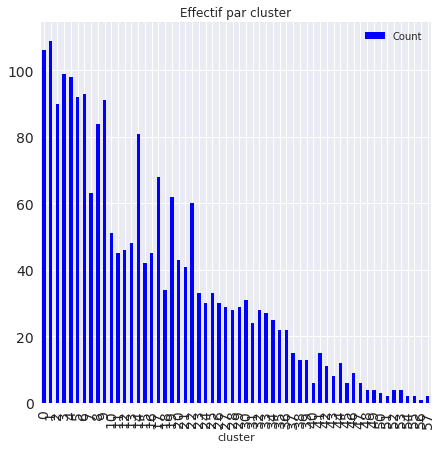

In [39]:
import p5_util
import p5_util_plot
if 'cluster' in df_customers.columns:
    del(df_customers['cluster'])
    
pred_gmm = gmm_model.predict(df_customers.values)
print(df_customers.shape)
df_customers = p5_util.df_add_cluster(df_customers, pred_gmm)
print(df_customers.shape)
p5_util_plot.plot_cluster_frequency(df_customers)

#### Backup of RFM dataframe per customer

In [40]:
import p5_util

#-----------------------------------------------------------------
# cluster column is filtered 
#-----------------------------------------------------------------
list_col = [col for col in df_customers.columns if col not in ['cluster'] ]

fileName = './data/df_customers_rfm.dump'
p5_util.object_dump(df_customers[list_col], fileName)

In [41]:
import p5_util
fileName = './data/df_RFM.dump'
df = p5_util.object_load(fileName)
print(df.shape)

p5_util.object_load : fileName= ./data/df_RFM.dump
(2124, 9)


In [42]:
df.sample(1)

,CustomerID,Frequency,Recency,Monatary,neg_recency,R_score,F_score,M_score,RFM
274,13562,3,81,1799.33,-233,4,2,1,421


In [43]:
df.index = df.CustomerID
df.rename(columns={'CustomerID':'CustID'}, inplace=True)
df.sample(1)

,CustID,Frequency,Recency,Monatary,neg_recency,R_score,F_score,M_score,RFM
CustomerID,,,,,,,,,
13867,13867,3,30,1005.09,-192,4,2,2,422


In [44]:
df = pd.concat([df,df_customers],axis=1, join='inner')

In [45]:
df_customers.sample(1)

,cluster,w_rfm_0,w_rfm_1,w_rfm_2,w_rfm_3,w_rfm_4,w_rfm_5,w_rfm_6,w_rfm_7,w_rfm_8,...,w_rfm_49,w_rfm_50,w_rfm_51,w_rfm_52,w_rfm_53,w_rfm_54,w_rfm_55,w_rfm_56,w_rfm_57,w_rfm_58
CustomerID,,,,,,,,,,,,,,,,,,,,,
14527,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#df.loc[18220]

In [47]:
for cluster in range(0,32):
    print("Cluster : "+str(cluster), "RFM = "+str(df[df.cluster==cluster][['RFM','cluster']]['RFM'].unique()))

Cluster : 0 RFM = ['144']
Cluster : 1 RFM = ['344']
Cluster : 2 RFM = ['311']
Cluster : 3 RFM = ['444']
Cluster : 4 RFM = ['244']
Cluster : 5 RFM = ['411']
Cluster : 6 RFM = ['111']
Cluster : 7 RFM = ['343']
Cluster : 8 RFM = ['222']
Cluster : 9 RFM = ['211']
Cluster : 10 RFM = ['122']
Cluster : 11 RFM = ['333']
Cluster : 12 RFM = ['133']
Cluster : 13 RFM = ['143']
Cluster : 14 RFM = ['322']
Cluster : 15 RFM = ['421']
Cluster : 16 RFM = ['433']
Cluster : 17 RFM = ['422']
Cluster : 18 RFM = ['321']
Cluster : 19 RFM = ['243']
Cluster : 20 RFM = ['233']
Cluster : 21 RFM = ['432']
Cluster : 22 RFM = ['443']
Cluster : 23 RFM = ['123']
Cluster : 24 RFM = ['132']
Cluster : 25 RFM = ['221']
Cluster : 26 RFM = ['121']
Cluster : 27 RFM = ['134']
Cluster : 28 RFM = ['323']
Cluster : 29 RFM = ['332']
Cluster : 30 RFM = ['223']
Cluster : 31 RFM = ['423']


In [53]:
import p3_util_plot
p3_util_plot.printmd("Number of RFM features= "+str(len(df['RFM'].unique())))

<p><font color='green'>**Number of RFM features= 59**</font></p>

### Print some observations from different clusters

In [50]:
cluster=0
#print("Cluster : "+str(cluster), "RFM = "+str(df[df.cluster==cluster]))
customerID = df[df.cluster==cluster]['CustID'].iloc[0]
print("CustomerID = "+str(customerID))

df_invoice_line[df_invoice_line.CustomerID==customerID]

CustomerID = 16976


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Total,RFM
38851,546874,84947,ANTIQUE SILVER TEA GLASS ENGRAVED,72,15051,1.06,16976,76.32,144
38852,546874,22423,REGENCY CAKESTAND 3 TIER,16,15051,10.95,16976,175.20,144


In [51]:
cluster=5
#print("Cluster : "+str(cluster), "RFM = "+str(df[df.cluster==cluster]))
customerID = df[df.cluster==cluster]['CustID'].iloc[0]
print("CustomerID = "+str(customerID))

df_invoice_line[df_invoice_line.CustomerID==customerID]

CustomerID = 12747


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Total,RFM
3110,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,14949,2.55,12747,30.60,411
3111,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,14949,2.55,12747,15.30,411
3112,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,14949,1.69,12747,27.04,411
3113,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,14949,1.65,12747,39.60,411
3114,537215,85064,CREAM SWEETHEART LETTER RACK,6,14949,5.45,12747,32.70,411
3115,537215,82484,WOOD BLACK BOARD ANT WHITE FINISH,36,14949,5.55,12747,199.80,411
3116,537215,21136,PAINTED METAL PEARS ASSORTED,8,14949,1.69,12747,13.52,411
8540,538537,22795,SWEETHEART RECIPE BOOK STAND,16,14956,5.95,12747,95.20,411
8541,538537,48138,DOORMAT UNION FLAG,2,14956,7.95,12747,15.90,411
8542,538537,82494L,WOODEN FRAME ANTIQUE WHITE,24,14956,2.55,12747,61.20,411
